# CNN Cancer Detection Kaggle Mini-Project

Viacheslav Sergeev viacheslav.sergeev@colorado.edu

University of Colorado Boulder

Source: https://www.kaggle.com/competitions/histopathologic-cancer-detection

## Problem

Problem description from Kaggle:

In this competition, you must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).

## Data

Data description from Kaggle:

In this dataset, you are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

The original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates. We have otherwise maintained the same data and splits as the PCam benchmark.




# EDA
## Data Loading

I'm downloading the data using Kaggle API and unpack it

In [5]:
!mkdir -p /root/.config/kaggle
!mv kaggle.json /root/.config/kaggle/kaggle.json
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.30G/6.31G [01:17<00:00, 78.8MB/s]
100% 6.31G/6.31G [01:17<00:00, 87.7MB/s]


In [ ]:
import zipfile
import os

with zipfile.ZipFile('histopathologic-cancer-detection.zip', 'r') as zip_ref:
  zip_ref.extractall('dataset')

In [79]:
import pandas as pd

train_labels = pd.read_csv('dataset/train_labels.csv')
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


## Data Preview

Then I check the data

In [80]:
train_folder = os.listdir("dataset/train")
test_folder = os.listdir("dataset/test")

count_of_train_samples = len(train_folder)
count_of_test_samples = len(test_folder)

print('DATASET SIZE')
print(f'{count_of_train_samples} train samples, {count_of_test_samples} test samples')

DATASET SIZE
220025 train samples, 57458 test samples


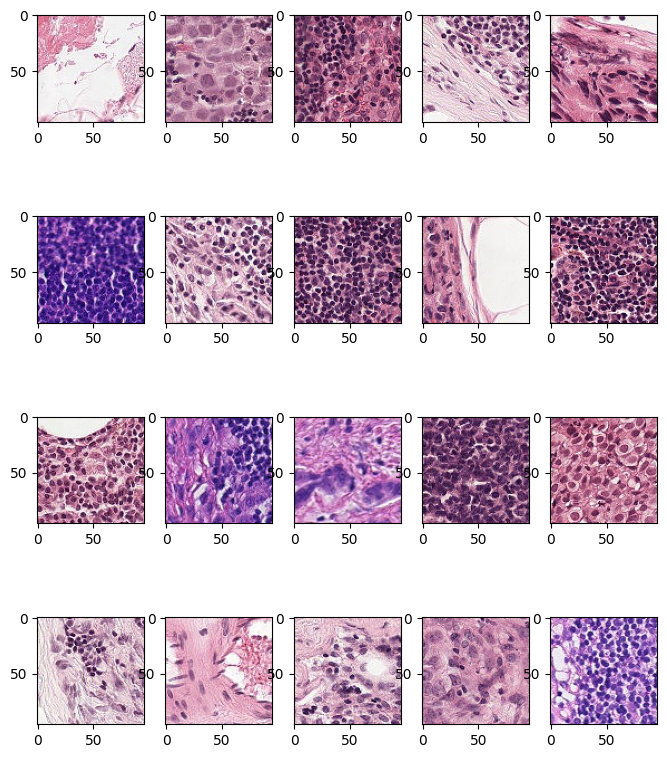

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

fig = plt.figure(figsize=(4*2, 20//4*2))
for _, img in enumerate(train_folder[:20]):
    ax = fig.add_subplot(4, 20//4, _+1)
    plt.imshow(Image.open(f"dataset/train/{img}"))

# Model building and training

## Torch loader

We need to create data loaders to pass the data inside the model

In [106]:
from torch.utils.data import TensorDataset, DataLoader,Dataset


class CancerDataset(Dataset):
    def __init__(
        self,
        datafolder,
        datatype='train',
        transform = transforms.Compose([
            transforms.CenterCrop(32),
            transforms.ToTensor()
        ]),
        labels_dict = {}
    ) -> None:
        self.datafolder = datafolder
        self.datatype = datatype
        self.images = [x for x in os.listdir(datafolder)]
        self.transform = transform
        self.labels_dict = labels_dict

        self.labels = [0 for _ in range(len(self.images))]
        if self.datatype == 'train':
            self.labels = [self.labels_dict[i.split('.')[0]] for i in self.images]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.datafolder, self.images[idx])
        image = self.transform(Image.open(img_name))
        label = self.labels[idx]

        return image, label

In [111]:
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

train_, test_ = train_test_split(train_labels.label, test_size=0.10)
train_, test_ = list(train_.index), list(test_.index)
BATCH = 512

dataset = CancerDataset(
    datafolder='dataset/train/',
    datatype='train',
    transform=transforms.Compose([
      transforms.CenterCrop(32),
      transforms.RandomHorizontalFlip(),
      transforms.RandomVerticalFlip(),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    labels_dict=dict(zip(train_labels.id, train_labels.label))
  )
submission_data = CancerDataset(
    datafolder='dataset/test/',
    datatype='test',
    transform=transforms.Compose([
      transforms.CenterCrop(32),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
  )

loaders = {}
loaders['train'] = torch.utils.data.DataLoader(
    dataset,
    batch_size=BATCH,
    sampler=SubsetRandomSampler(train_),
    num_workers=0
)
loaders['valid'] = torch.utils.data.DataLoader(
    dataset,
    batch_size=BATCH,
    sampler=SubsetRandomSampler(test_),
    num_workers=0
  )
loaders['test'] = torch.utils.data.DataLoader(
    submission_data,
    batch_size=BATCH,
    num_workers=0
  )

## Architecture

Then I design neural network layers

In [112]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)
        self.dropout = nn.Dropout(0.2)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.sig(self.fc3(x))
        return x

## Training & Evaluation

Then I train and evaluate the model. I use SDG optimizator and step scheduler for learning rate. I also added early stopping for training on the design step but then I realized that even 2 epochs gives good enough result for Kaggle.

In [113]:
import torch.optim as optim
from torch.optim import lr_scheduler

model = Model()
model.cuda()

criterion = nn.BCELoss()
sgd = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(sgd, step_size=5, gamma=0.1)

In [114]:
import time
from sklearn.metrics import roc_auc_score

MIN_LOSS_VALIDATION = np.Inf
EARLY_FLAG_PATIENCE = 7
PATIENCE_COUNTER = 0
EARLY_STOP_FLAG = False
EPOCHS_N = 2

for epoch in range(1, EPOCHS_N+1):
    print(time.ctime(), 'EPOCH ', epoch)
    training_losses = []
    scheduler.step()
    training_AUCs = []
    for batch_i, (data, target) in enumerate(loaders['train']):
        data, target = data.cuda(), target.cuda()
        sgd.zero_grad()
        output = model(data)
        loss = criterion(output[:,1], target.float())
        training_losses.append(loss.item())

        x = target.data.cpu().numpy()
        y = output[:,-1].detach().cpu().numpy()
        training_AUCs.append(roc_auc_score(x, y))
        loss.backward()
        sgd.step()

    model.eval()
    validation_losses = []
    validation_AUCs = []
    for batch_i, (data, target) in enumerate(loaders['valid']):
        data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output[:,1], target.float())
        validation_losses.append(loss.item())
        x = target.data.cpu().numpy()
        y = output[:,-1].detach().cpu().numpy()
        validation_AUCs.append(roc_auc_score(x, y))

    print(f'EPOCH {epoch}, loss - {np.median(training_losses)}')
    print(f'valid loss - {np.median(validation_losses)}')
    print(f'train AUC - {np.median(training_AUCs)}')
    print(f'valid acc - {np.median(validation_AUCs)}')

    loss_validation = np.median(validation_losses)
    if loss_validation <= MIN_LOSS_VALIDATION:
        print(f'decrease LOSS (valid) ({MIN_LOSS_VALIDATION}->{loss_validation}). checkpoint!')
        torch.save(model.state_dict(), 'checkpoint.pt')
        MIN_LOSS_VALIDATION = loss_validation
        PATIENCE_COUNTER = 0

    if loss_validation > MIN_LOSS_VALIDATION:
        PATIENCE_COUNTER += 1
        print(f'{PATIENCE_COUNTER} epochs of increasing val loss')
        if PATIENCE_COUNTER > EARLY_FLAG_PATIENCE:
            print('STOP')
            EARLY_STOP_FLAG = True
            break

    if EARLY_STOP_FLAG:
        break

Fri Oct  4 01:29:13 2024 EPOCH  1


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


UnidentifiedImageError: cannot identify image file '/content/dataset/train/63eaaa1ff98548e72e1334726bf593216bd3d80f.tif'

## Kaggle Submission - Score: 0.8072

I'm using pre-trained model

In [115]:
model.eval()
final_predictions = []
for batch_i, (data, target) in enumerate(loaders['test']):
    output = model(data.cuda())
    pr = output[:,1].detach().cpu().numpy()
    for i in pr:
        final_predictions.append(i)

In [116]:
submission = pd.DataFrame({'id': submission_data.image_files_list, 'label': final_predictions})
submission['id'] = submission['id'].apply(lambda x: x.split('.')[0])
submission.to_csv('output.csv', index=False)

In [117]:
!kaggle competitions submit -c histopathologic-cancer-detection -f output.csv -m "Submission"

100% 2.83M/2.83M [00:00<00:00, 4.22MB/s]
Successfully submitted to Histopathologic Cancer Detection

# Conclusion

The final score is 0.8. I think it's possible to increase it just scaling compute and increasing the number of epochs because 3 is definitely not enough, but I think just compute capabilities are limited and need to try another more complex architecture. Maybe some tricky preprocessing could help too like highlighting all edges on the picture or something like this. Also, I think that I need to make better EDA because current one is very limited but on the other hand there are not that many options for EDA for computer vision tasks.